# Adaboost
Vamos a ver primero un pequeño ejemplo de juguete para entender como funcionan AdaBoost.

Como siempre, empezamos con las librerias.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import numpy as np
import seaborn as sns
sns.set_style('white')
%matplotlib inline

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

Vamos ahora con el dataset de juguete que hemos creado.

In [10]:
#Toy Dataset
x1 = np.array([.1,.2,.4,.8, .8, .05,.08,.12,.33,.55,.66,.77,.88,.2,.3,.4,.5,.6,.25,.3,.5,.7,.6])
x2 = np.array([.2,.65,.7,.6, .3,.1,.4,.66,.77,.65,.68,.55,.44,.1,.3,.4,.3,.15,.15,.5,.55,.2,.4])
y = np.array([1,1,1,1,1,1,1,1,1,1,1,1,1,-1,-1,-1,-1,-1,-1,-1,-1,-1,-1])
X = np.vstack((x1,x2)).T

Vamos a visualizar los datos como siempre:


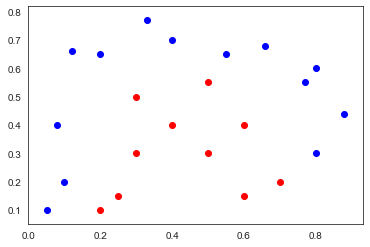

In [19]:
plt.figure()
plt.scatter(x1[y==1],x2[y==1],color="blue")
plt.scatter(x1[y==-1],x2[y==-1],color="red")
plt.show()

Vamos ahora a ver como podemos implementar el Adaboost.

## Implementación del Adaboost 


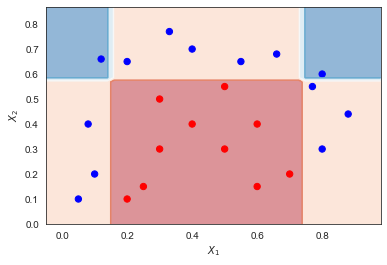

1.0

In [4]:
boost = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2), 
                            algorithm = 'SAMME',n_estimators=10, learning_rate=1.0)
boost.fit(X,y)
plot_decision_boundary(boost, X,y, N = 50)#, weights)
plt.show()

boost.score(X,y)

In [22]:
def AdaBoost_scratch(X,y, M=10, learning_rate = 1):
    #Inicializamos las variables
    N = len(y)
    estimator_list, y_predict_list, estimator_error_list, estimator_weight_list, sample_weight_list = [], [],[],[],[]

    #Inizializamos los pesos
    sample_weight = np.ones(N) / N
    sample_weight_list.append(sample_weight.copy())

    for m in range(M):   

        #Genera un clasificador
        estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
        estimator.fit(X, y, sample_weight=sample_weight)
        y_predict = estimator.predict(X)

        #Calcula cuantos errores se han generado
        incorrect = (y_predict != y)

        #Estimador del error
        estimator_error = np.mean( np.average(incorrect, weights=sample_weight, axis=0))
        
        #Aplicamos el boosting de los pesos
        estimator_weight =  learning_rate * np.log((1.0 - estimator_error) / estimator_error)

        sample_weight *= np.exp(estimator_weight * incorrect * ((sample_weight > 0) | (estimator_weight < 0)))

        #Guardamos el avance
        estimator_list.append(estimator)
        y_predict_list.append(y_predict.copy())
        estimator_error_list.append(estimator_error.copy())
        estimator_weight_list.append(estimator_weight.copy())
        sample_weight_list.append(sample_weight.copy())
        

    #Convertir a np array
    estimator_list = np.asarray(estimator_list)
    y_predict_list = np.asarray(y_predict_list)
    estimator_error_list = np.asarray(estimator_error_list)
    estimator_weight_list = np.asarray(estimator_weight_list)
    sample_weight_list = np.asarray(sample_weight_list)

    #Predecimos
    preds = (np.array([np.sign((y_predict_list[:,point] * estimator_weight_list).sum()) for point in range(N)]))
    print('Accuracy = ', (preds == y).sum() / N) 
    
    return estimator_list, estimator_weight_list, sample_weight_list

Vamos a ver ahora como funciona nuestro algoritmo.

In [23]:
estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X,y, M=10, learning_rate = 1)

Accuracy =  1.0


 Aamos a visualizar como ha evolucionado en cada iteración, necesitamos crearnos esta visualizacion por zonas con matplotlib:

In [25]:
def plot_AdaBoost_scratch_boundary(estimators,estimator_weights, X, y, N = 10,ax = None ):
    
    def AdaBoost_scratch_classify(x_temp, est,est_weights ):
        '''Return classification prediction for a given point X and a previously fitted AdaBoost'''
        temp_pred = np.asarray( [ (e.predict(x_temp)).T* w for e, w in zip(est,est_weights )]  ) / est_weights.sum()
        return np.sign(temp_pred.sum(axis = 0))
    
    
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))


    zz = np.array( [AdaBoost_scratch_classify(np.array([xi,yi]).reshape(1,-1), estimators,estimator_weights ) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
            
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='RdBu')
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')

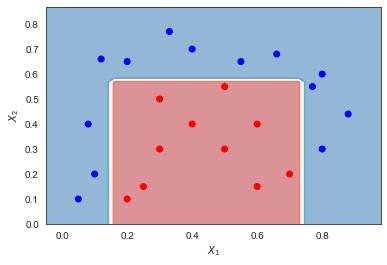

In [26]:
plot_AdaBoost_scratch_boundary(estimator_list, estimator_weight_list, X, y, N = 50 )


Accuracy =  1.0


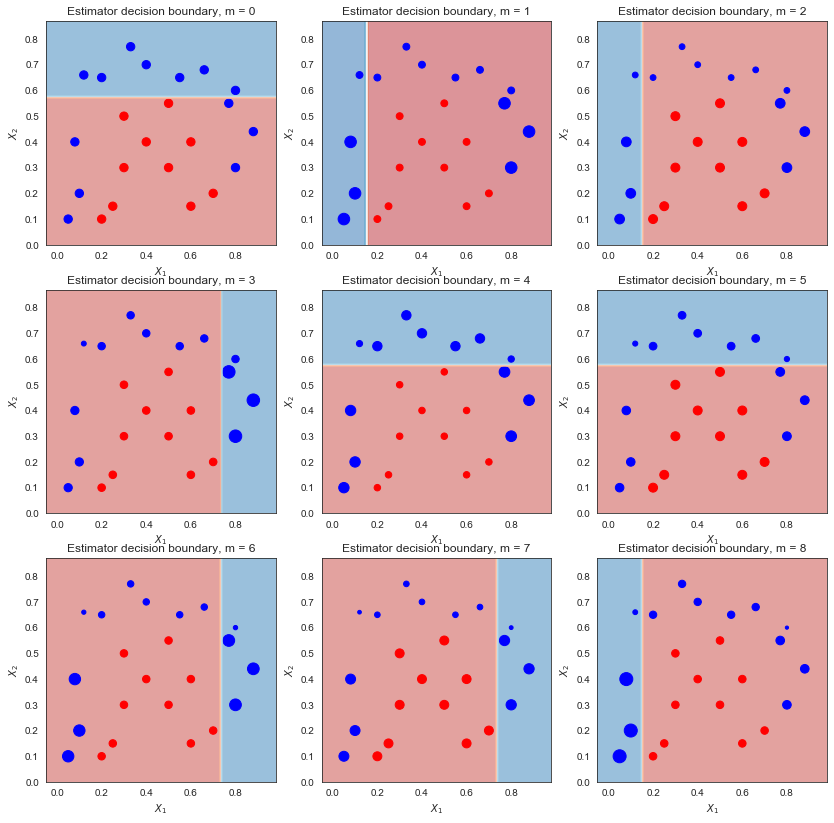

In [28]:
estimator_list, estimator_weight_list, sample_weight_list  = AdaBoost_scratch(X,y, M=10, learning_rate = 1)

fig = plt.figure(figsize = (14,14))
for m in range(0,9):
    fig.add_subplot(3,3,m+1)
    s_weights = (sample_weight_list[m,:] / sample_weight_list[m,:].sum() ) * 40
    plot_decision_boundary(estimator_list[m], X,y,N = 50, scatter_weights =s_weights )
    plt.title('Estimator decision boundary, m = {}'.format(m))

# Scikit Implementation
Ahora hacerlo con scikit i a ver que solución os da. Para poder hacer la visualización igual, podeis usar la siguiente función, donde en "classifier" teneis que pasarle un objeto de scikit.


In [29]:
def plot_decision_boundary(classifier, X, y, N = 10, scatter_weights = np.ones(len(y)) , ax = None ):
    '''Utility function to plot decision boundary and scatter plot of data'''
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid( np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))

    
    #Check what methods are available
    if hasattr(classifier, "decision_function"):
        zz = np.array( [classifier.decision_function(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    elif hasattr(classifier, "predict_proba"):
        zz = np.array( [classifier.predict_proba(np.array([xi,yi]).reshape(1,-1))[:,1] for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
    else :
        zz = np.array( [classifier(np.array([xi,yi]).reshape(1,-1)) for  xi, yi in zip(np.ravel(xx), np.ravel(yy)) ] )
            
    # reshape result and plot
    Z = zz.reshape(xx.shape)
    cm_bright = ListedColormap(['#FF0000', '#0000FF'])
    
    #Get current axis and plot
    if ax is None:
        ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap='RdBu', alpha=.5)
    ax.contour(xx, yy, Z,  2, cmap='RdBu')
    ax.scatter(X[:,0],X[:,1], c = y, cmap = cm_bright, s = scatter_weights * 40)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')

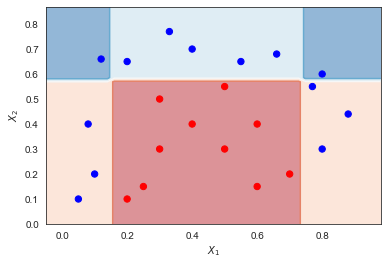

0.7391304347826086

In [34]:
boost = AdaBoostClassifier( base_estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2), 
                            algorithm = 'SAMME',n_estimators=4, learning_rate=1.0)
boost.fit(X,y)
plot_decision_boundary(boost, X,y, N = 50)#, weights)
plt.show()

boost.score(X,y)

# XGBoost
Utilizando el dataset de predicción de diabetes, utiliza AdaBoost y XGBoost para predecir cuando el usuario tendrá diabetes. El dataset es de https://www.kaggle.com/uciml/pima-indians-diabetes-database

In [36]:
pip install --user xgboost

Note: you may need to restart the kernel to use updated packages.


Cargamos las librerias

In [38]:
from numpy import loadtxt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Ahora vamos a cargar los datos:

In [56]:
dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")

X = dataset[:,0:8]
Y = dataset[:,8]

seed = 7
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size, random_state=seed)


Vamos ahora a entrenar con XGB:

In [67]:
# Entrenamos el modelo
model = XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

# Evaluamos las predicciones

In [68]:
# Hacemos las predicciones
y_pred = model.predict(X_test)

# Evaluamos las predicciones
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 74.02%


In [63]:
boost = AdaBoostClassifier()
boost.fit(X_train, y_train)

y_pred = boost.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

Accuracy: 72.44%
